In [1]:
# default_exp models.nbeats.nbeats

In [2]:
#hide
%load_ext autoreload
%autoreload 2

In [3]:
#export
import os
import time
import numpy as np
import pandas as pd
import random
from collections import defaultdict
import copy

import torch as t
from torch import optim
from pathlib import Path
from functools import partial

from nixtla.models.nbeats.nbeats_model import NBeats, NBeatsBlock, IdentityBasis, TrendBasis, SeasonalityBasis
from nixtla.models.nbeats.nbeats_model import ExogenousBasisInterpretable, ExogenousBasisWavenet, ExogenousBasisTCN
from nixtla.losses.pytorch import MAPELoss, MASELoss, SMAPELoss, MSELoss, MAELoss, PinballLoss
from nixtla.losses.numpy import mae, mse, mape, smape, rmse, pinball_loss


In [11]:
#export
def init_weights(module, initialization):
    if type(module) == t.nn.Linear:
        if initialization == 'orthogonal':
            t.nn.init.orthogonal_(module.weight)
        elif initialization == 'he_uniform':
            t.nn.init.kaiming_uniform_(module.weight)
        elif initialization == 'he_normal':
            t.nn.init.kaiming_normal_(module.weight)
        elif initialization == 'glorot_uniform':
            t.nn.init.xavier_uniform_(module.weight)
        elif initialization == 'glorot_normal':
            t.nn.init.xavier_normal_(module.weight)
        elif initialization == 'lecun_normal':
            pass #t.nn.init.normal_(module.weight, 0.0, std=1/np.sqrt(module.weight.numel()))
        else:
            assert 1<0, f'Initialization {initialization} not found'

class Nbeats(object):
    """
    Future documentation
    """
    SEASONALITY_BLOCK = 'seasonality'
    TREND_BLOCK = 'trend'
    IDENTITY_BLOCK = 'identity'

    def __init__(self,
                 input_size_multiplier,
                 output_size,
                 shared_weights,
                 activation,
                 initialization,
                 stack_types,
                 n_blocks,
                 n_layers,
                 n_hidden,
                 n_harmonics,
                 n_polynomials,
                 exogenous_n_channels,
                 include_var_dict,
                 t_cols,
                 batch_normalization,
                 dropout_prob_theta,
                 dropout_prob_exogenous,
                 x_s_n_hidden,
                 learning_rate,
                 lr_decay,
                 n_lr_decay_steps,
                 weight_decay,
                 l1_theta,
                 n_iterations,
                 early_stopping,
                 loss,
                 loss_hypar,
                 frequency,
                 random_seed,
                 seasonality,
                 device=None):
        super(Nbeats, self).__init__()

        if activation == 'selu': initialization = 'lecun_normal'

        #------------------------ Model Attributes ------------------------#
        # Architecture parameters
        self.input_size = int(input_size_multiplier*output_size)
        self.output_size = output_size
        self.shared_weights = shared_weights
        self.activation = activation
        self.initialization = initialization
        self.stack_types = stack_types
        self.n_blocks = n_blocks
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_harmonics = n_harmonics
        self.n_polynomials = n_polynomials
        self.exogenous_n_channels = exogenous_n_channels

        # Regularization and optimization parameters
        self.batch_normalization = batch_normalization
        self.dropout_prob_theta = dropout_prob_theta
        self.dropout_prob_exogenous = dropout_prob_exogenous
        self.x_s_n_hidden = x_s_n_hidden
        self.learning_rate = learning_rate
        self.lr_decay = lr_decay
        self.n_lr_decay_steps = n_lr_decay_steps
        self.weight_decay = weight_decay
        self.n_iterations = n_iterations
        self.early_stopping = early_stopping
        self.loss = loss
        self.loss_hypar = loss_hypar
        self.l1_theta = l1_theta
        self.l1_conv = 1e-3 # Not a hyperparameter
        self.random_seed = random_seed

        # Data parameters
        self.frequency = frequency
        self.seasonality = seasonality        
        self.include_var_dict = include_var_dict
        self.t_cols = t_cols
        #self.scaler = scaler

        if device is None:
            device = 'cuda' if t.cuda.is_available() else 'cpu'
        self.device = device

        self._is_instantiated = False

    def create_stack(self):
        if self.include_var_dict is not None:
            x_t_n_inputs = self.output_size * int(sum([len(x) for x in self.include_var_dict.values()]))
            
            # Correction because week_day only adds 1 no output_size
            if len(self.include_var_dict['week_day'])>0:
                x_t_n_inputs = x_t_n_inputs - self.output_size + 1 
        else:
            x_t_n_inputs = self.input_size
        
        #------------------------ Model Definition ------------------------#
        block_list = []
        self.blocks_regularizer = []
        for i in range(len(self.stack_types)):
            #print(f'| --  Stack {self.stack_types[i]} (#{i})')
            for block_id in range(self.n_blocks[i]):
                
                # Batch norm only on first block
                if (len(block_list)==0) and (self.batch_normalization):
                    batch_normalization_block = True
                else:
                    batch_normalization_block = False
                
                # Dummy of regularizer in block. Override with 1 if exogenous_block
                self.blocks_regularizer += [0]

                # Shared weights
                if self.shared_weights and block_id>0:
                    nbeats_block = block_list[-1]
                else:
                    if self.stack_types[i] == 'seasonality':
                        nbeats_block = NBeatsBlock(x_t_n_inputs = x_t_n_inputs,
                                                   x_s_n_inputs = self.n_x_s,
                                                   x_s_n_hidden= self.x_s_n_hidden,
                                                   theta_n_dim=4 * int(
                                                        np.ceil(self.n_harmonics / 2 * self.output_size) - (self.n_harmonics - 1)),
                                                   basis=SeasonalityBasis(harmonics=self.n_harmonics,
                                                                          backcast_size=self.input_size,
                                                                          forecast_size=self.output_size),
                                                   n_layers=self.n_layers[i],
                                                   theta_n_hidden=self.n_hidden[i],
                                                   include_var_dict=self.include_var_dict,
                                                   t_cols=self.t_cols,
                                                   batch_normalization=batch_normalization_block,
                                                   dropout_prob=self.dropout_prob_theta,
                                                   activation=self.activation)
                    elif self.stack_types[i] == 'trend':
                        nbeats_block = NBeatsBlock(x_t_n_inputs = x_t_n_inputs,
                                                   x_s_n_inputs = self.n_x_s,
                                                   x_s_n_hidden= self.x_s_n_hidden,
                                                   theta_n_dim=2 * (self.n_polynomials + 1),
                                                   basis=TrendBasis(degree_of_polynomial=self.n_polynomials,
                                                                            backcast_size=self.input_size,
                                                                            forecast_size=self.output_size),
                                                   n_layers=self.n_layers[i],
                                                   theta_n_hidden=self.n_hidden[i],
                                                   include_var_dict=self.include_var_dict,
                                                   t_cols=self.t_cols,
                                                   batch_normalization=batch_normalization_block,
                                                   dropout_prob=self.dropout_prob_theta,
                                                   activation=self.activation)
                    elif self.stack_types[i] == 'identity':
                        nbeats_block = NBeatsBlock(x_t_n_inputs = x_t_n_inputs,
                                                   x_s_n_inputs = self.n_x_s,
                                                   x_s_n_hidden= self.x_s_n_hidden,
                                                   theta_n_dim=self.input_size + self.output_size,
                                                   basis=IdentityBasis(backcast_size=self.input_size,
                                                                       forecast_size=self.output_size),
                                                   n_layers=self.n_layers[i],
                                                   theta_n_hidden=self.n_hidden[i],
                                                   include_var_dict=self.include_var_dict,
                                                   t_cols=self.t_cols,
                                                   batch_normalization=batch_normalization_block,
                                                   dropout_prob=self.dropout_prob_theta,
                                                   activation=self.activation)
                    elif self.stack_types[i] == 'exogenous':
                        nbeats_block = NBeatsBlock(x_t_n_inputs = x_t_n_inputs,
                                                   x_s_n_inputs = self.n_x_s,
                                                   x_s_n_hidden= self.x_s_n_hidden,
                                                   theta_n_dim=2*self.n_x_t,
                                                   basis=ExogenousBasisInterpretable(),
                                                   n_layers=self.n_layers[i],
                                                   theta_n_hidden=self.n_hidden[i],
                                                   include_var_dict=self.include_var_dict,
                                                   t_cols=self.t_cols,
                                                   batch_normalization=batch_normalization_block,
                                                   dropout_prob=self.dropout_prob_theta,
                                                   activation=self.activation)
                    elif self.stack_types[i] == 'exogenous_tcn':
                        nbeats_block = NBeatsBlock(x_t_n_inputs = x_t_n_inputs,
                                                   x_s_n_inputs = self.n_x_s,
                                                   x_s_n_hidden = self.x_s_n_hidden,
                                                   theta_n_dim = 2*(self.exogenous_n_channels),
                                                   basis= ExogenousBasisTCN(self.exogenous_n_channels, self.n_x_t),
                                                   n_layers=self.n_layers[i],
                                                   theta_n_hidden=self.n_hidden[i],
                                                   include_var_dict=self.include_var_dict,
                                                   t_cols=self.t_cols,
                                                   batch_normalization=batch_normalization_block,
                                                   dropout_prob=self.dropout_prob_theta,
                                                   activation=self.activation)
                    elif self.stack_types[i] == 'exogenous_wavenet':
                        nbeats_block = NBeatsBlock(x_t_n_inputs = x_t_n_inputs,
                                                   x_s_n_inputs = self.n_x_s,
                                                   x_s_n_hidden= self.x_s_n_hidden,
                                                   theta_n_dim=2*(self.exogenous_n_channels),
                                                   basis=ExogenousBasisWavenet(self.exogenous_n_channels, self.n_x_t),
                                                   n_layers=self.n_layers[i],
                                                   theta_n_hidden=self.n_hidden[i],
                                                   include_var_dict=self.include_var_dict,
                                                   t_cols=self.t_cols,
                                                   batch_normalization=batch_normalization_block,
                                                   dropout_prob=self.dropout_prob_theta,
                                                   activation=self.activation)
                        self.blocks_regularizer[-1] = 1
                    else:
                        assert 1<0, f'Block type not found!'
                # Select type of evaluation and apply it to all layers of block
                init_function = partial(init_weights, initialization=self.initialization)                                             
                nbeats_block.layers.apply(init_function)
                #print(f'     | -- {nbeats_block}')
                block_list.append(nbeats_block)
        return block_list

    def __loss_fn(self, loss_name: str):
        def loss(x, loss_hypar, forecast, target, mask):
            if loss_name == 'MAPE':
                return MAPELoss(y=target, y_hat=forecast, mask=mask) + \
                       self.loss_l1_conv_layers() + self.loss_l1_theta()
            elif loss_name == 'MASE':
                return MASELoss(y=target, y_hat=forecast, y_insample=x, seasonality=loss_hypar, mask=mask) + \
                       self.loss_l1_conv_layers() + self.loss_l1_theta()
            elif loss_name == 'SMAPE':
                return SMAPELoss(y=target, y_hat=forecast, mask=mask) + \
                       self.loss_l1_conv_layers() + self.loss_l1_theta()
            elif loss_name == 'MSE':
                return MSELoss(y=target, y_hat=forecast, mask=mask) + \
                       self.loss_l1_conv_layers() + self.loss_l1_theta()
            elif loss_name == 'MAE':
                return MAELoss(y=target, y_hat=forecast, mask=mask) + \
                       self.loss_l1_conv_layers() + self.loss_l1_theta()
            elif loss_name == 'PINBALL':
                return PinballLoss(y=target, y_hat=forecast, mask=mask, tau=loss_hypar) + \
                       self.loss_l1_conv_layers() + self.loss_l1_theta()
            else:
                raise Exception(f'Unknown loss function: {loss_name}')
        return loss

    def __val_loss_fn(self, loss_name='MAE'):
        #TODO: mase not implemented
        def loss(forecast, target, weights):
            if loss_name == 'MAPE':
                return mape(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'SMAPE':
                return smape(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'MSE':
                return mse(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'RMSE':
                return rmse(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'MAE':
                return mae(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'PINBALL':
                return pinball_loss(y=target, y_hat=forecast, weights=weights, tau=0.5)
            else:
                raise Exception(f'Unknown loss function: {loss_name}')
        return loss
    
    def loss_l1_conv_layers(self):
        loss_l1 = 0
        for i, indicator in enumerate(self.blocks_regularizer):
            if indicator:
                loss_l1 += self.l1_conv * t.sum(t.abs(self.model.blocks[i].basis.weight))
        return loss_l1
    
    def loss_l1_theta(self):
        loss_l1 = 0
        for block in self.model.blocks:
            for layer in block.modules():
                if isinstance(layer, t.nn.Linear):
                    loss_l1 += self.l1_theta * layer.weight.abs().sum()
        return loss_l1

    def to_tensor(self, x: np.ndarray) -> t.Tensor:
        tensor = t.as_tensor(x, dtype=t.float32).to(self.device)
        return tensor

    def evaluate_performance(self, ts_loader, validation_loss_fn):
        self.model.eval()

        losses = []
        with t.no_grad():
            for batch in iter(ts_loader):
                # Parse batch
                insample_y     = self.to_tensor(batch['insample_y'])
                insample_x     = self.to_tensor(batch['insample_x'])
                insample_mask  = self.to_tensor(batch['insample_mask'])
                outsample_x    = self.to_tensor(batch['outsample_x'])
                outsample_y    = self.to_tensor(batch['outsample_y'])
                outsample_mask = self.to_tensor(batch['outsample_mask'])
                s_matrix       = self.to_tensor(batch['s_matrix'])

                forecast   = self.model(x_s=s_matrix, insample_y=insample_y, 
                                        insample_x_t=insample_x, outsample_x_t=outsample_x,
                                        insample_mask=insample_mask)
                batch_loss = validation_loss_fn(target=forecast.cpu().data.numpy(),
                                                forecast=outsample_y.cpu().data.numpy(),
                                                weights=outsample_mask.cpu().data.numpy())
                losses.append(batch_loss)
        loss = np.mean(losses)
        self.model.train()
        return loss

    def fit(self, train_ts_loader, val_ts_loader=None, n_iterations=None, verbose=True, eval_steps=1):
        # TODO: Indexes hardcoded, information duplicated in train and val datasets
        assert (self.input_size)==train_ts_loader.input_size, \
            f'model input_size {self.input_size} data input_size {train_ts_loader.input_size}'

        # Random Seeds (model initialization)
        t.manual_seed(self.random_seed)
        np.random.seed(self.random_seed)
        random.seed(self.random_seed) #TODO: interaccion rara con window_sampling de validacion

        # Attributes of ts_dataset
        self.n_x_t, self.n_x_s = train_ts_loader.get_n_variables()

        # Instantiate model
        if not self._is_instantiated:
            block_list = self.create_stack()
            self.model = NBeats(t.nn.ModuleList(block_list)).to(self.device)
            self._is_instantiated = True

        # Overwrite n_iterations and train datasets
        if n_iterations is None:
            n_iterations = self.n_iterations

        lr_decay_steps = n_iterations // self.n_lr_decay_steps
        if lr_decay_steps == 0:
            lr_decay_steps = 1

        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_steps, gamma=self.lr_decay)
        training_loss_fn = self.__loss_fn(self.loss)
        validation_loss_fn = self.__val_loss_fn(self.loss) #Uses numpy losses

        print('='*30+' Start fitting '+'='*30)

        #self.loss_dict = {} # Restart self.loss_dict
        start = time.time()
        self.trajectories = {'iteration':[],'train_loss':[], 'val_loss':[]}
        self.final_insample_loss = None
        self.final_outsample_loss = None
        
        # Training Loop
        early_stopping_counter = 0
        best_val_loss = np.inf
        best_state_dict = copy.deepcopy(self.model.state_dict())
        break_flag = False
        iteration = 0
        epoch = 0
        while (iteration < n_iterations) and (not break_flag):
            epoch +=1
            for batch in iter(train_ts_loader):
                iteration += 1
                if (iteration > n_iterations) or (break_flag):
                    continue

                self.model.train()
                # Parse batch
                insample_y     = self.to_tensor(batch['insample_y'])
                insample_x     = self.to_tensor(batch['insample_x'])
                insample_mask  = self.to_tensor(batch['insample_mask'])
                outsample_x    = self.to_tensor(batch['outsample_x'])
                outsample_y    = self.to_tensor(batch['outsample_y'])
                outsample_mask = self.to_tensor(batch['outsample_mask'])
                s_matrix       = self.to_tensor(batch['s_matrix'])

                optimizer.zero_grad()
                forecast   = self.model(x_s=s_matrix, insample_y=insample_y, 
                                        insample_x_t=insample_x, outsample_x_t=outsample_x,
                                        insample_mask=insample_mask)

                training_loss = training_loss_fn(x=insample_y, loss_hypar=self.loss_hypar, forecast=forecast,
                                                 target=outsample_y, mask=outsample_mask)

                if np.isnan(float(training_loss)):
                    break

                training_loss.backward()
                t.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()

                lr_scheduler.step()
                if (iteration % eval_steps == 0):
                    display_string = 'Step: {}, Time: {:03.3f}, Insample {}: {:.5f}'.format(iteration,
                                                                                    time.time()-start,
                                                                                    self.loss,
                                                                                    training_loss.cpu().data.numpy())
                    self.trajectories['iteration'].append(iteration)
                    self.trajectories['train_loss'].append(training_loss.cpu().data.numpy())

                    if val_ts_loader is not None:
                        loss = self.evaluate_performance(ts_loader=val_ts_loader, 
                                                         validation_loss_fn=validation_loss_fn)
                        display_string += ", Outsample {}: {:.5f}".format(self.loss, loss)
                        self.trajectories['val_loss'].append(loss)

                        if self.early_stopping:
                            if loss < best_val_loss:
                                # Save current model if improves outsample loss
                                best_state_dict = copy.deepcopy(self.model.state_dict())
                                best_insample_loss = training_loss.cpu().data.numpy()
                                early_stopping_counter = 0
                                best_val_loss = loss
                            else:
                                early_stopping_counter += 1
                            if early_stopping_counter >= self.early_stopping:
                                break_flag = True
                    
                    print(display_string)

                    self.model.train()

                if break_flag:
                    print(18*'-',' Stopped training  by early stopping', 18*'-')
                    self.model.load_state_dict(best_state_dict)
                    break

        #End of fitting
        if n_iterations >0:
            self.final_insample_loss = training_loss.cpu().data.numpy() if not break_flag else best_insample_loss #This is batch!
            string = 'Step: {}, Time: {:03.3f}, Insample {}: {:.5f}'.format(iteration,
                                                                            time.time()-start,
                                                                            self.loss,
                                                                            self.final_insample_loss)
            if val_ts_loader is not None:
                self.final_outsample_loss = self.evaluate_performance(ts_loader=val_ts_loader, 
                                                                      validation_loss_fn=validation_loss_fn)
                string += ", Outsample {}: {:.5f}".format(self.loss, self.final_outsample_loss)
            print(string)
            print('='*30+'  End fitting  '+'='*30)
            print('\n')

    def predict(self, ts_loader, X_test=None, eval_mode=False):
        self.model.eval()
        assert not ts_loader.shuffle, 'ts_loader must have shuffle as False.'

        forecasts = []
        outsample_ys = []
        outsample_masks = []
        with t.no_grad():
            for batch in iter(ts_loader):
                insample_y     = self.to_tensor(batch['insample_y'])
                insample_x     = self.to_tensor(batch['insample_x'])
                insample_mask  = self.to_tensor(batch['insample_mask'])
                outsample_x    = self.to_tensor(batch['outsample_x'])
                s_matrix       = self.to_tensor(batch['s_matrix'])

                forecast = self.model(insample_y=insample_y, insample_x_t=insample_x,
                                      insample_mask=insample_mask, outsample_x_t=outsample_x, x_s=s_matrix)
                forecasts.append(forecast.cpu().data.numpy())
                outsample_ys.append(batch['outsample_y'])
                outsample_masks.append(batch['outsample_mask'])
        forecasts = np.vstack(forecasts)
        outsample_ys = np.vstack(outsample_ys)
        outsample_masks = np.vstack(outsample_masks)

        self.model.train()
        if eval_mode:
            return outsample_ys, forecasts, outsample_masks

        # Pandas wrangling
        frequency = ts_loader.get_frequency()
        unique_ids = ts_loader.get_meta_data_col('unique_id')
        last_ds = ts_loader.get_meta_data_col('last_ds') #TODO: ajustar of offset

        # Predictions for panel
        Y_hat_panel = pd.DataFrame(columns=['unique_id', 'ds'])
        for i, unique_id in enumerate(unique_ids):
            Y_hat_id = pd.DataFrame([unique_id]*self.output_size, columns=["unique_id"])
            ds = pd.date_range(start=last_ds[i], periods=self.output_size+1, freq=frequency)
            Y_hat_id["ds"] = ds[1:]
            Y_hat_panel = Y_hat_panel.append(Y_hat_id, sort=False).reset_index(drop=True)

        Y_hat_panel['y_hat'] = forecasts.flatten()

        if X_test is not None:
            Y_hat_panel = X_test.merge(Y_hat_panel, on=['unique_id', 'ds'], how='left')
        
        return Y_hat_panel


    def save(self, model_dir, model_id, state_dict = None):
    
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)

        if state_dict is None:
            state_dict = self.model.state_dict()

        model_file = os.path.join(model_dir, f"model_{model_id}.model")
        print('Saving model to:\n {}'.format(model_file)+'\n')
        t.save({'model_state_dict': state_dict}, model_file)

    def load(self, model_dir, model_id):

        model_file = os.path.join(model_dir, f"model_{model_id}.model")
        path = Path(model_file)

        assert path.is_file(), 'No model_*.model file found in this path!'

        print('Loading model from:\n {}'.format(model_file)+'\n')

        checkpoint = t.load(model_file, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(self.device)

# SINGLE TIME SERIES TEST

In [19]:
import matplotlib.pyplot as plt

from nixtla.data.scalers import Scaler
from nixtla.data.tsdataset import TimeSeriesDataset
from nixtla.data.tsloader_fast import TimeSeriesLoader
#from nixtla.data.tsloader_general import TimeSeriesLoader

from nixtla.data.datasets.epf import EPF, EPFInfo

mc = {'input_size_multiplier': 7,
      'output_size': 24,
      'window_sampling_limit': 365*4*24,
      'idx_to_sample_freq': 24,
      'batch_size': 256,
      'shared_weights': False,
      'activation': 'relu',
      'initialization': 'lecun_normal',
      'stack_types': 2*['identity'],
      'n_blocks': 2*[1],
      'n_layers': 2*[2],
      'n_hidden': 2*[[256,256]],
      'n_polynomials': 2,
      'n_harmonics': 1,
      'exogenous_n_channels': 9,
      'include_var_dict': {'y': [-2, -3, -8],
                           'Exogenous1': [-1, -2, -8],
                           'Exogenous2': [-1, -2, -8],
                           'week_day': [-1]},
      'batch_normalization': False,
      'dropout_prob_theta': 0.01,
      'dropout_prob_exogenous': 0.01,
      'x_s_n_hidden': 0,
      'learning_rate': 0.007,
      'lr_decay': 0.5,
      'n_lr_decay_steps': 3,
      'weight_decay': 0.0000001,
      'l1_theta': 0.0001,
      'n_iterations': 500,
      'early_stopping': 10,
      'loss': 'MAE',
      'loss_hypar': 0.5,
      'frequency': 'H',
      'random_seed': 1,
      'seasonality': 24}

In [20]:
def run_val_nbeatsx(mc, Y_df, Xt_df, val_ds): #, trials, trials_file_name):

    offset = val_ds * mc['output_size']

    # To not modify original data
    Xt_scaled_df = Xt_df.copy()

    # Transform data with scale transformation
    scaler = Scaler(normalizer='norm')
    Xt_scaled_df['Exogenous1'] = scaler.scale(x=Xt_scaled_df['Exogenous1'].values, offset=offset)

    scaler = Scaler(normalizer='norm')
    Xt_scaled_df['Exogenous2'] = scaler.scale(x=Xt_scaled_df['Exogenous2'].values, offset=offset)

    # train_mask: 1 to keep, 0 to mask
    train_outsample_mask = np.ones(len(Y_df))
    train_outsample_mask[-val_ds * mc['output_size']:] = 0

    ts_dataset = TimeSeriesDataset(Y_df=Y_df, S_df=None, X_df=Xt_scaled_df, 
                                   ts_train_mask=train_outsample_mask)

    print("\n")
    print('EPFInfo.groups[0]', EPFInfo.groups[0])
    #print("X_df.columns", X_df.columns)
    print(f'Train mask percentage: {np.round(np.sum(train_outsample_mask)/len(train_outsample_mask),2)}')
    print('X: time series features, of shape (#hours, #times,#features): \t' + str(Xt_df.shape))
    print('Y: target series (in X), of shape (#hours, #times): \t \t' + str(Y_df.shape))
    print(f'{len(Xt_df)} hours = {np.round(len(Xt_df)/(24*365),2)} years')
    # print('S: static features, of shape (#series,#features): \t \t' + str(S.shape))
    #Y_df.head()
    print("\n")

    train_loader = TimeSeriesLoader(ts_dataset=ts_dataset,
                                    model='nbeats',
                                    offset=0, #offset,
                                    window_sampling_limit=int(mc['window_sampling_limit']), 
                                    input_size=int(mc['input_size_multiplier']*mc['output_size']),
                                    output_size=int(mc['output_size']),
                                    idx_to_sample_freq=int(mc['idx_to_sample_freq']),
                                    batch_size=int(mc['batch_size']),
                                    is_train_loader=True,
                                    shuffle=True)

    val_loader = TimeSeriesLoader(ts_dataset=ts_dataset,
                                  model='nbeats',
                                  offset=0, #offset,
                                  window_sampling_limit=int(mc['window_sampling_limit']), 
                                  input_size=int(mc['input_size_multiplier']*mc['output_size']),
                                  output_size=int(mc['output_size']),
                                  idx_to_sample_freq=int(mc['idx_to_sample_freq']),
                                  batch_size=1024,
                                  is_train_loader=False, # Samples the opposite of train_outsample_mask
                                  shuffle=False)

    model = Nbeats(input_size_multiplier=int(mc['input_size_multiplier']),
                   output_size=int(mc['output_size']),
                   shared_weights=int(mc['shared_weights']),
                   activation=mc['activation'],
                   initialization=mc['initialization'],
                   stack_types=mc['stack_types'], #2*['identity'],
                   n_blocks=mc['n_blocks'], #2*[1],
                   n_layers=mc['n_layers'], #2*[2],
                   n_hidden=mc['n_hidden'], #2*[[256,256]],
                   n_polynomials=mc['n_polynomials'], #2,
                   n_harmonics=int(mc['n_harmonics']), #1,
                   exogenous_n_channels=int(mc['exogenous_n_channels']), #9,
                   include_var_dict={'y': [-2, -3, -8],
                                     'Exogenous1': [-1, -2, -8],
                                     'Exogenous2': [-1, -2, -8],
                                     'week_day': [-1]},
                   t_cols=ts_dataset.t_cols,
                   batch_normalization=mc['batch_normalization'], #False,
                   dropout_prob_theta=float(mc['dropout_prob_theta']), #0.01,
                   dropout_prob_exogenous=float(mc['dropout_prob_exogenous']), #0.01,
                   x_s_n_hidden=int(mc['x_s_n_hidden']), #0,
                   learning_rate=float(mc['learning_rate']), #0.007,
                   lr_decay=float(mc['lr_decay']), #0.5,
                   n_lr_decay_steps=int(mc['n_lr_decay_steps']), #3,
                   weight_decay=float(mc['weight_decay']), #0.0000001,
                   l1_theta=float(mc['l1_theta']), #0.0001,
                   n_iterations=int(mc['n_iterations']), #200,
                   early_stopping=int(mc['early_stopping']), #40,
                   loss=mc['loss'], #'MAE',
                   loss_hypar=float(mc['loss_hypar']), #0.5,
                   frequency=mc['frequency'], #'H',
                   random_seed=int(mc['random_seed']), #1,
                   seasonality=int(mc['seasonality'])) #24)

    model.fit(train_ts_loader=train_loader, val_ts_loader=val_loader, verbose=True, eval_steps=10)

    return model, train_loader, val_loader

In [21]:
Y_df, Xt_df = EPF.load(directory='../data/', group='NP')
model, train_loader, val_loader = run_val_nbeatsx(mc, Y_df, Xt_df, val_ds=365)

Processing dataframes ...
Creating ts tensor ...


EPFInfo.groups[0] NP
Train mask percentage: 0.75
X: time series features, of shape (#hours, #times,#features): 	(34944, 12)
Y: target series (in X), of shape (#hours, #times): 	 	(34944, 3)
34944 hours = 3.99 years


============================== Start fitting ==============================
Step: 10, Time: 0.253, Insample MAE: 3.20491, Outsample MAE: 2.65639
Step: 20, Time: 0.520, Insample MAE: 2.75604, Outsample MAE: 2.58354
Step: 30, Time: 0.797, Insample MAE: 2.60012, Outsample MAE: 2.33848
Step: 40, Time: 1.066, Insample MAE: 2.61366, Outsample MAE: 2.35031
Step: 50, Time: 1.345, Insample MAE: 2.15834, Outsample MAE: 2.11483
Step: 60, Time: 1.626, Insample MAE: 2.39707, Outsample MAE: 2.14586
Step: 70, Time: 1.911, Insample MAE: 2.20275, Outsample MAE: 2.21431
Step: 80, Time: 2.180, Insample MAE: 2.41623, Outsample MAE: 2.13348
Step: 90, Time: 2.447, Insample MAE: 1.97928, Outsample MAE: 2.03311
Step: 100, Time: 2.721, Insample MA

y_hat.shape  		(#fcds, #lt) 	 (8760,)
y_plot.shape 		(#fcds,) 	 (8760,)




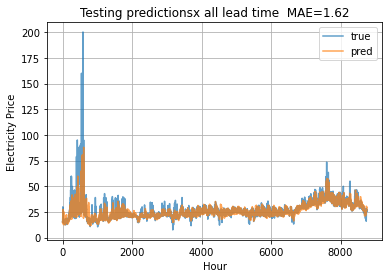

In [22]:
y_true, y_hat, _ = model.predict(ts_loader=val_loader, eval_mode=True)
y_plot = Y_df['y'][-len(y_hat)*24:] #[-2*168:]
y_hat = y_hat.reshape(-1)#[-2*168:]
#lead_time = 23
#y_hat_plot1 = y_hat[-2*168:, lead_time] # Forecast lead_time=?, for the last week
#y_hat_plot2 = y_hat[-1, :]
#y_hat_plot = np.concatenate([y_hat_plot1, y_hat_plot2])

print("y_hat.shape  \t\t(#fcds, #lt) \t", y_hat.shape)
print("y_plot.shape \t\t(#fcds,) \t", y_plot.shape)
#print("y_true.shape \t\t(#fcds,) \t", y_true.shape)
# print("y_hat_plot1.shape \t(#fcds, lt=0) \t", y_hat_plot1.shape)
# print("y_hat_plot2.shape \t(#fcds, lt=0) \t", y_hat_plot2.shape)
print("\n")

mae0 = np.round(mae(y_plot, y_hat), 2)
plt.plot(range(len(y_plot)), y_plot, label='true', alpha=0.7)
plt.plot(range(len(y_hat)), y_hat, label='pred', alpha=0.7)
plt.title(f"Testing predictionsx all lead time  MAE={mae0}")
plt.xlabel('Hour')
plt.ylabel('Electricity Price')
plt.legend()
plt.grid()
plt.show()

In [ ]:
def forecast_evaluation_table(y_true, y_hat):
    print("y_true.shape", y_true.shape)
    print("y_hat.shape", y_hat.shape)

    n_days = len(y_true) // 24
    y_true = y_true[-n_days*24:, :]
    y_hat  = y_hat[-n_days*24:, :]

    print("y_true.shape (#fcds, #lt)", y_true.shape)
    print("y_hat.shape  (#fcds, #lt)", y_hat.shape)

    y_true = y_true.reshape(n_days, 24, 24)
    y_hat = y_hat.reshape(n_days, 24, 24)

    print("y_true.shape (#fcd_day, #fcd_hour, #lt)", y_true.shape)
    print("y_hat.shape (#fcd_day, #fcd_hour, #lt)", y_hat.shape)
    
    _mae   = np.round(mae(y_true[:,0,:], y_hat[:,0,:]),2)
    _mape  = np.round(mape(y_true[:,0,:], y_hat[:,0,:]),2)
    _smape = np.round(smape(y_true[:,0,:], y_hat[:,0,:]),2)
    _rmse  = np.round(rmse(y_true[:,0,:], y_hat[:,0,:]),2)

    evaluations = pd.Series({'mae': _mae, 'mape': _mape, 'smape': _smape, 'rmse': _rmse})

    return evaluations

evaluations = forecast_evaluation_table(y_true, y_hat)
print(evaluations)